# 경제 분석 및 예측과 데이터 지능 실습2: Prophet, NeuralProphet

본 실습은 시계열 예측을 위한 데이터 전처리와 대표적인 모듈 "Prophet", "NeuralProphet" 활용법을 다루고 있습니다.

References:
- [Modern Time Series Forecasting Techniques](https://medium.com/dataman-in-ai/mastering-time-series-forecasting-from-classical-foundations-to-cutting-edge-applications-0-1b0ac3da3188)
- [Introduction to Statistical Learning](https://www.statlearning.com/)
- [Prophet](https://facebook.github.io/prophet/)
- [Neuralprophet](https://neuralprophet.com/)
- [pmdarima](https://alkaline-ml.com/pmdarima/)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn import metrics
import logging
import warnings
logging.getLogger("prophet").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

### Prophet

Meta에서 개발한 시계열 예측 라이브러리로, 비즈니스 환경에서 복잡한 패턴을 효과적으로 모델링하기 위해 고안되어 널리 활용되고 있습니다.

Prophet은 Generalized Additive Model (GAM) 기반으로 작동하는데, 이는 각 구성요소를 가법적으로 결합하여 전체 시계열을 설명하는 모델입니다.

Prophet의 모델의 표현:

$Y(t)=T(t)+S(t)+H(t)+ϵ(t)$

- T: 트렌드
- S: 계절성
- H: 휴일
- $\epsilon$ : 오차


In [2]:
path = '../datasets'
data = pd.read_csv(path + '/daily-website-visitors.csv', thousands=',')

data["Date"] = pd.to_datetime(data["Date"])
data = data[['First.Time.Visits','Date']]
data.columns = ["y", "ds"]
data["y"] = pd.to_numeric(data["y"], errors='coerce')
data = data[data["ds"] >= pd.to_datetime('2017-01-01')]
data = data.sort_values(by='ds')
data

,y,ds
840,832,2017-01-01
841,1448,2017-01-02
842,1970,2017-01-03
843,2226,2017-01-04
844,2058,2017-01-05
...,...,...
2162,1373,2020-08-15
2163,1686,2020-08-16
2164,2181,2020-08-17
2165,2184,2020-08-18


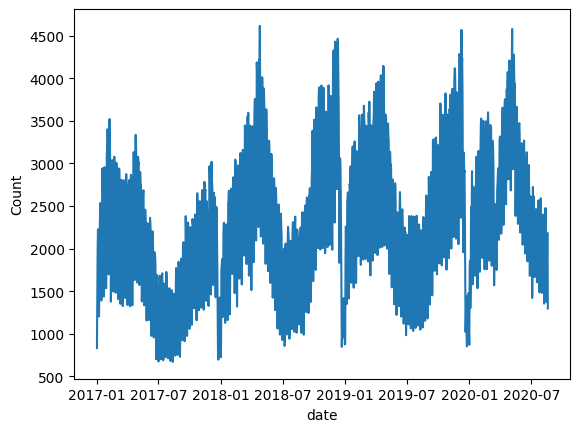

In [3]:
plt.plot(data['ds'], data["y"])
plt.xlabel("date")
plt.ylabel("Count")
plt.show() 

In [4]:
train_len = int(data.shape[0] * 0.85)
train = data.iloc[:train_len,:]
test = data.iloc[train_len:,:]
[train_len, len(test)]
# [1127, 200]

[1127, 200]

In [5]:
m = Prophet()
m.add_country_holidays(country_name='US')
m.fit(train)

future= m.make_future_dataframe(periods=len(test), freq='d')
print(future.tail())

forecast=m.predict(future)
forecast.tail()

15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing


             ds
1322 2020-08-15
1323 2020-08-16
1324 2020-08-17
1325 2020-08-18
1326 2020-08-19


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1322,2020-08-15,2520.448667,527.420027,1296.993669,2340.674378,2700.962581,0.0,0.0,0.0,0.0,...,-919.178791,-919.178791,-919.178791,-685.001872,-685.001872,-685.001872,0.0,0.0,0.0,916.268005
1323,2020-08-16,2520.360098,981.360751,1747.861311,2338.949612,2702.113772,0.0,0.0,0.0,0.0,...,-469.819035,-469.819035,-469.819035,-677.544571,-677.544571,-677.544571,0.0,0.0,0.0,1372.996491
1324,2020-08-17,2520.271528,1905.953082,2646.846784,2337.224846,2703.280001,0.0,0.0,0.0,0.0,...,425.117208,425.117208,425.117208,-670.074228,-670.074228,-670.074228,0.0,0.0,0.0,2275.314508
1325,2020-08-18,2520.182959,1924.447887,2721.752795,2335.500080,2703.781745,0.0,0.0,0.0,0.0,...,472.940813,472.940813,472.940813,-662.613406,-662.613406,-662.613406,0.0,0.0,0.0,2330.510366
1326,2020-08-19,2520.094389,1916.078262,2662.298821,2333.775315,2705.974724,0.0,0.0,0.0,0.0,...,435.699464,435.699464,435.699464,-655.154461,-655.154461,-655.154461,0.0,0.0,0.0,2300.639393


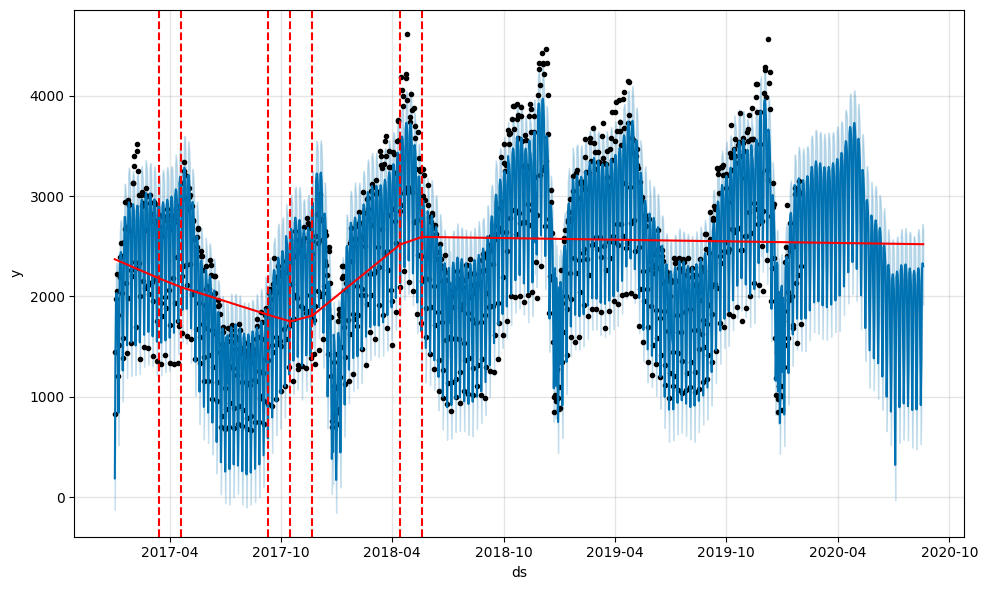

In [6]:
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [7]:
mape = metrics.mean_absolute_percentage_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
mae = metrics.mean_absolute_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))
mse = metrics.mean_squared_error(list(test['y']), list(forecast.loc[train_len:,'yhat']))

print(f' mape: {mape}')
print(f'mae : {mae}')
print(f'mse : {mse}')

 mape: 0.15783652705190943
mae : 397.9044808468297
mse : 239356.14747815428


In [8]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

  0%|          | 0/1 [00:00<?, ?it/s]

15:25:55 - cmdstanpy - INFO - Chain [1] start processing
15:25:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-02-02,1859.400848,1547.545154,2165.153741,1596,2019-02-01
1,2019-02-03,2296.534861,1985.077019,2613.368868,2044,2019-02-01
2,2019-02-04,3152.612731,2868.013174,3477.341469,3146,2019-02-01
3,2019-02-05,3218.909274,2922.093592,3556.297458,3124,2019-02-01
4,2019-02-06,3164.603816,2848.380142,3478.592670,3130,2019-02-01


In [9]:
m_perf = performance_metrics(df_cv)
m_perf.head() 

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days,31549.618556,177.622123,137.081279,0.048639,0.041482,0.049036,0.888889
1,37 days,29630.359391,172.134713,130.234909,0.044250,0.039395,0.044998,0.888889
2,38 days,31460.580295,177.371306,133.222436,0.043598,0.039395,0.044691,0.861111
3,39 days,31585.617868,177.723431,134.911450,0.044094,0.039395,0.045193,0.861111
4,40 days,37497.131668,193.641761,145.357862,0.046762,0.041482,0.048110,0.833333


### 하이퍼 패러미터 찾기

In [10]:
# Define hyper-parameter grids
changepoint_prior_scale = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5]
seasonality_prior_scale = [1, 5, 10, 15]  # default 10
seasonality_model = ['additive', 'multiplicative']

results = []
iteration = 1

# Loop over all combinations of hyper-parameters
for sm in seasonality_model:
    for s in seasonality_prior_scale:
        for cp in changepoint_prior_scale:
            m = Prophet(
                seasonality_mode=sm,
                seasonality_prior_scale=s,
                changepoint_prior_scale=cp,
            )
            m.add_country_holidays(country_name='US')
            model = m.fit(train)
            future = model.make_future_dataframe(periods=len(test), freq='D')
            forecast = model.predict(future)
            # Compute evaluation metrics on the test set;
            # assume 'train_len' holds the length of the training set
            mape = metrics.mean_absolute_percentage_error(
                list(test['y']),
                list(forecast.loc[train_len:, 'yhat'])
            )
            mae = metrics.mean_absolute_error(
                list(test['y']),
                list(forecast.loc[train_len:, 'yhat'])
            )
            mse = metrics.mean_squared_error(
                list(test['y']),
                list(forecast.loc[train_len:, 'yhat'])
            )
            print(f'Iteration {iteration} -- mape: {mape}')
            results.append([iteration, sm, s, cp, mape, mae, mse])
            iteration += 1

# Convert results list to a DataFrame
results = pd.DataFrame(
    results,
    columns=['iteration', 'seasonality_mode', 'seasonality_prior_scale',
             'changepoint_prior_scale', 'mape', 'mae', 'mse']
)

results.head()

15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing
15:25:56 - cmdstanpy - INFO - Chain [1] start processing
15:25:56 - cmdstanpy - INFO - Chain [1] done processing


Iteration 1 -- mape: 0.12534862618724982


15:25:57 - cmdstanpy - INFO - Chain [1] start processing


Iteration 2 -- mape: 0.17595495751322612


15:25:57 - cmdstanpy - INFO - Chain [1] done processing
15:25:57 - cmdstanpy - INFO - Chain [1] start processing


Iteration 3 -- mape: 0.21259086352494427


15:25:57 - cmdstanpy - INFO - Chain [1] done processing
15:25:58 - cmdstanpy - INFO - Chain [1] start processing


Iteration 4 -- mape: 0.19969854999842362


15:25:58 - cmdstanpy - INFO - Chain [1] done processing
15:25:58 - cmdstanpy - INFO - Chain [1] start processing


Iteration 5 -- mape: 0.1550360710916173


15:25:58 - cmdstanpy - INFO - Chain [1] done processing
15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration 6 -- mape: 0.10654425060903612


15:25:59 - cmdstanpy - INFO - Chain [1] start processing
15:25:59 - cmdstanpy - INFO - Chain [1] done processing


Iteration 7 -- mape: 0.12187184463496151


15:25:59 - cmdstanpy - INFO - Chain [1] start processing


Iteration 8 -- mape: 0.17748084194985506


15:25:59 - cmdstanpy - INFO - Chain [1] done processing
15:26:00 - cmdstanpy - INFO - Chain [1] start processing


Iteration 9 -- mape: 0.2134182551523983


15:26:00 - cmdstanpy - INFO - Chain [1] done processing
15:26:00 - cmdstanpy - INFO - Chain [1] start processing


Iteration 10 -- mape: 0.20704959889193855


15:26:00 - cmdstanpy - INFO - Chain [1] done processing
15:26:01 - cmdstanpy - INFO - Chain [1] start processing


Iteration 11 -- mape: 0.15300186662541918


15:26:01 - cmdstanpy - INFO - Chain [1] done processing
15:26:01 - cmdstanpy - INFO - Chain [1] start processing
15:26:01 - cmdstanpy - INFO - Chain [1] done processing


Iteration 12 -- mape: 0.10780962368985485


15:26:01 - cmdstanpy - INFO - Chain [1] start processing


Iteration 13 -- mape: 0.12299807542078811


15:26:02 - cmdstanpy - INFO - Chain [1] done processing
15:26:02 - cmdstanpy - INFO - Chain [1] start processing
15:26:02 - cmdstanpy - INFO - Chain [1] done processing


Iteration 14 -- mape: 0.18036347635069233


15:26:02 - cmdstanpy - INFO - Chain [1] start processing


Iteration 15 -- mape: 0.2104171864455392


15:26:02 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing


Iteration 16 -- mape: 0.19377516581559512


15:26:03 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing


Iteration 17 -- mape: 0.15347869856321159


15:26:03 - cmdstanpy - INFO - Chain [1] done processing
15:26:03 - cmdstanpy - INFO - Chain [1] start processing
15:26:03 - cmdstanpy - INFO - Chain [1] done processing


Iteration 18 -- mape: 0.10483387384856313


15:26:04 - cmdstanpy - INFO - Chain [1] start processing
15:26:04 - cmdstanpy - INFO - Chain [1] done processing


Iteration 19 -- mape: 0.12085442270582082


15:26:04 - cmdstanpy - INFO - Chain [1] start processing


Iteration 20 -- mape: 0.1751640634917354


15:26:04 - cmdstanpy - INFO - Chain [1] done processing
15:26:04 - cmdstanpy - INFO - Chain [1] start processing


Iteration 21 -- mape: 0.21049086214034488


15:26:05 - cmdstanpy - INFO - Chain [1] done processing
15:26:05 - cmdstanpy - INFO - Chain [1] start processing


Iteration 22 -- mape: 0.20626848398458936


15:26:05 - cmdstanpy - INFO - Chain [1] done processing
15:26:05 - cmdstanpy - INFO - Chain [1] start processing


Iteration 23 -- mape: 0.12836583447609143


15:26:06 - cmdstanpy - INFO - Chain [1] done processing
15:26:06 - cmdstanpy - INFO - Chain [1] start processing
15:26:06 - cmdstanpy - INFO - Chain [1] done processing


Iteration 24 -- mape: 0.11844817999230127


15:26:06 - cmdstanpy - INFO - Chain [1] start processing


Iteration 25 -- mape: 0.1561313050134858


15:26:06 - cmdstanpy - INFO - Chain [1] done processing
15:26:06 - cmdstanpy - INFO - Chain [1] start processing
15:26:07 - cmdstanpy - INFO - Chain [1] done processing


Iteration 26 -- mape: 0.18503605698769132


15:26:07 - cmdstanpy - INFO - Chain [1] start processing


Iteration 27 -- mape: 0.18282370504634532


15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:07 - cmdstanpy - INFO - Chain [1] start processing


Iteration 28 -- mape: 0.14658970259159781


15:26:07 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing


Iteration 29 -- mape: 0.1374561791176255


15:26:08 - cmdstanpy - INFO - Chain [1] done processing
15:26:08 - cmdstanpy - INFO - Chain [1] start processing
15:26:08 - cmdstanpy - INFO - Chain [1] done processing


Iteration 30 -- mape: 0.1379191185790138


15:26:09 - cmdstanpy - INFO - Chain [1] start processing
15:26:09 - cmdstanpy - INFO - Chain [1] done processing


Iteration 31 -- mape: 0.16170444680620888


15:26:09 - cmdstanpy - INFO - Chain [1] start processing


Iteration 32 -- mape: 0.18395872228632412


15:26:09 - cmdstanpy - INFO - Chain [1] done processing
15:26:09 - cmdstanpy - INFO - Chain [1] start processing


Iteration 33 -- mape: 0.17999481805067455


15:26:09 - cmdstanpy - INFO - Chain [1] done processing
15:26:10 - cmdstanpy - INFO - Chain [1] start processing


Iteration 34 -- mape: 0.1445436118606296


15:26:10 - cmdstanpy - INFO - Chain [1] done processing
15:26:10 - cmdstanpy - INFO - Chain [1] start processing


Iteration 35 -- mape: 0.13805768393503623


15:26:10 - cmdstanpy - INFO - Chain [1] done processing
15:26:11 - cmdstanpy - INFO - Chain [1] start processing
15:26:11 - cmdstanpy - INFO - Chain [1] done processing


Iteration 36 -- mape: 0.13976624251552608


15:26:11 - cmdstanpy - INFO - Chain [1] start processing


Iteration 37 -- mape: 0.1607441361606105


15:26:11 - cmdstanpy - INFO - Chain [1] done processing
15:26:11 - cmdstanpy - INFO - Chain [1] start processing


Iteration 38 -- mape: 0.18452237506905925


15:26:11 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


Iteration 39 -- mape: 0.18057102018279575


15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:12 - cmdstanpy - INFO - Chain [1] start processing


Iteration 40 -- mape: 0.14806915131198659


15:26:12 - cmdstanpy - INFO - Chain [1] done processing
15:26:13 - cmdstanpy - INFO - Chain [1] start processing


Iteration 41 -- mape: 0.13859191825822628


15:26:13 - cmdstanpy - INFO - Chain [1] done processing
15:26:13 - cmdstanpy - INFO - Chain [1] start processing
15:26:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration 42 -- mape: 0.13993110390444075


15:26:13 - cmdstanpy - INFO - Chain [1] start processing
15:26:13 - cmdstanpy - INFO - Chain [1] done processing


Iteration 43 -- mape: 0.1754817733656341


15:26:14 - cmdstanpy - INFO - Chain [1] start processing


Iteration 44 -- mape: 0.18552264383705314


15:26:14 - cmdstanpy - INFO - Chain [1] done processing
15:26:14 - cmdstanpy - INFO - Chain [1] start processing


Iteration 45 -- mape: 0.1781156323035247


15:26:14 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing


Iteration 46 -- mape: 0.14583325237925476


15:26:15 - cmdstanpy - INFO - Chain [1] done processing
15:26:15 - cmdstanpy - INFO - Chain [1] start processing


Iteration 47 -- mape: 0.13910379603064407


15:26:15 - cmdstanpy - INFO - Chain [1] done processing


Iteration 48 -- mape: 0.13926036651863444


,iteration,seasonality_mode,seasonality_prior_scale,changepoint_prior_scale,mape,mae,mse
0,1,additive,1,0.001,0.125349,311.197221,162906.059370
1,2,additive,1,0.100,0.175955,448.553588,291780.383156
2,3,additive,1,0.200,0.212591,547.626983,409106.168792
3,4,additive,1,0.300,0.199699,515.268926,366876.870512
4,5,additive,1,0.400,0.155036,399.323003,237265.366381


15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/4 [00:00<?, ?it/s]

15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:16 - cmdstanpy - INFO - Chain [1] start processing
15:26:16 - cmdstanpy - INFO - Chain [1] done processing
15:26:17 - cmdstanpy - INFO - Chain [1] start processing
15:26:17 - cmdstanpy - INFO - Chain [1] done processing
15:26:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
15:26:17 - cmdstanpy - INFO - Chai

  horizon            mse        rmse         mae      mape     mdape  \
0 37 days  407606.370873  638.440577  478.734991  0.295700  0.150364   
1 38 days  438253.974794  662.007534  490.756227  0.301210  0.150364   
2 39 days  479343.428187  692.346321  506.565915  0.305887  0.150364   
3 40 days  525400.644650  724.845256  525.844961  0.312841  0.164535   
4 41 days  585119.216125  764.930857  547.186147  0.321216  0.170842   

      smape  coverage  
0  0.351934  0.438356  
1  0.351965  0.438356  
2  0.351883  0.434932  
3  0.356489  0.424658  
4  0.361571  0.417808  


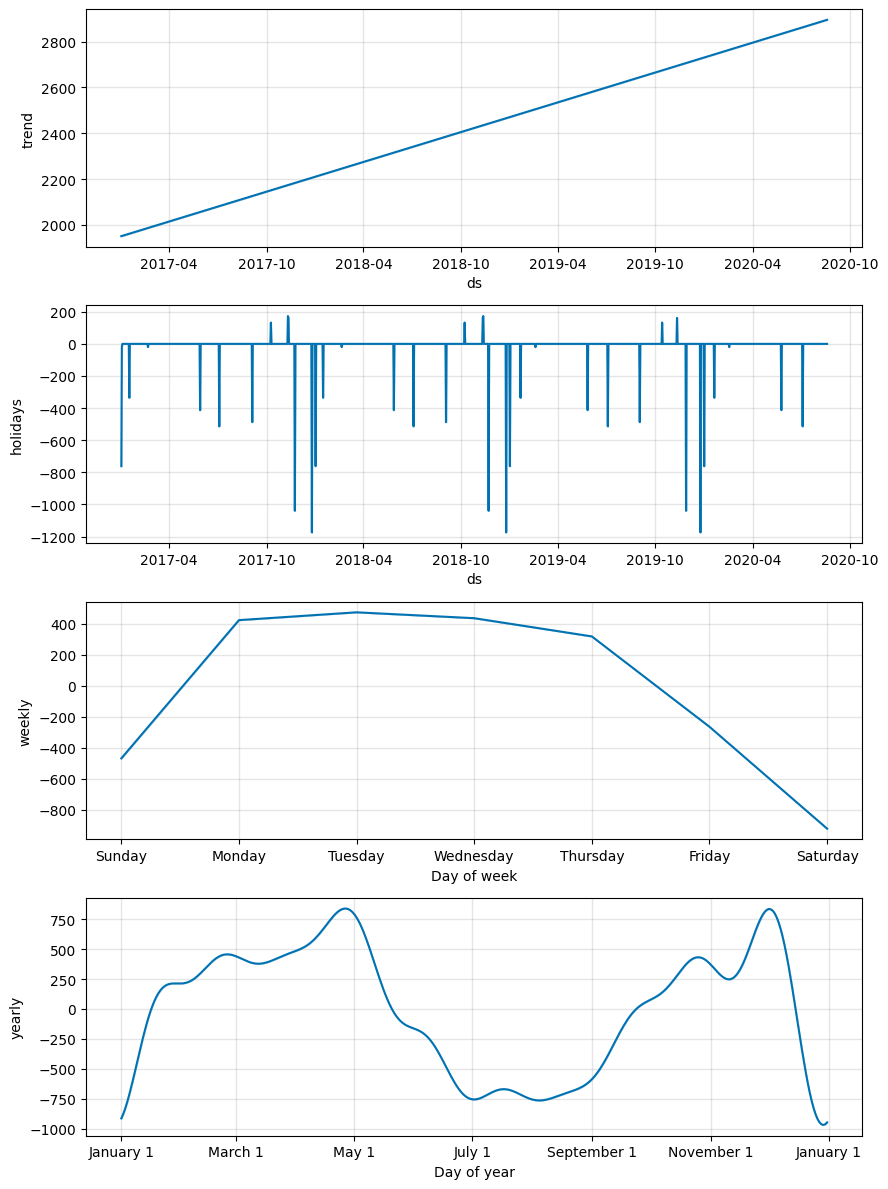

In [11]:
# Select the best model (first record in results) for diagnostics
sm_best = results.loc[0, 'seasonality_mode']
sp_best = results.loc[0, 'seasonality_prior_scale']
cp_best = results.loc[0, 'changepoint_prior_scale']

m1 = Prophet(
    seasonality_mode=sm_best,
    seasonality_prior_scale=sp_best,
    changepoint_range=cp_best,
)
m1.add_country_holidays(country_name='US')
m1.fit(train)
future = m1.make_future_dataframe(periods=len(test), freq='D')
forecast = m1.predict(future)

m1_cv = cross_validation(
    m1,
    initial='100 days',
    period='180 days',
    horizon='365 days'
)
m1_perf = performance_metrics(m1_cv)
print(m1_perf.head())

fig = m1.plot_components(forecast)


### Neuralprophet

NeuralProphet는 Prophet 모델의 확장판으로, 딥러닝 모듈을 도입하여 보다 복잡한 시계열 패턴을 모델링할 수 있습니다.

모델 구성:
$$
Y(t) = T(t) + S(t) + E(t) + A(t) + L(t) + F(t)
$$

- $T(t)$: 시계열의 추세(Trend)
- $S(t)$: 계절성(Seasonality)
- $E(t)$: 이벤트(Event) 효과
- $A(t)$: 자동회귀(Autoregressive) 성분
- $L(t)$: 레벨(Level) 변화
- $F(t)$: 잔차(Residual) 또는 기타 효과

In [12]:
data = pd.read_csv(path + "/bike_sharing_daily.csv")
data["ds"] = pd.to_datetime(data["dteday"])
data.tail()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,ds
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114,2012-12-27
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095,2012-12-28
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341,2012-12-29
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796,2012-12-30
730,731,2012-12-31,1,1,12,0,1,1,2,0.215833,0.223487,0.577500,0.154846,439,2290,2729,2012-12-31


In [13]:
df = data[["ds", "cnt"]]
df.columns = ["ds", "y"]

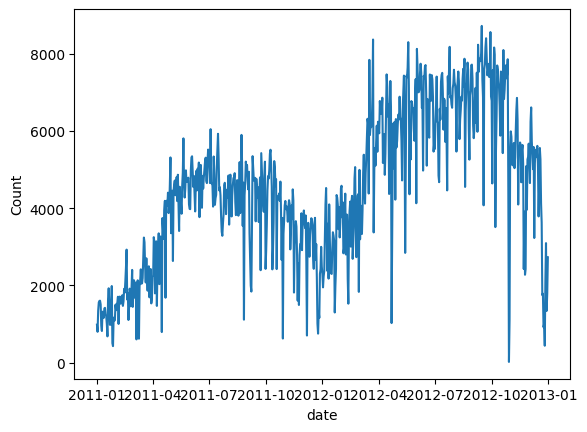

In [14]:
plt.plot(df['ds'], df["y"])
plt.xlabel("date")
plt.ylabel("Count")
plt.show() 

In [15]:
from neuralprophet import NeuralProphet, set_log_level
set_log_level("ERROR")

m = NeuralProphet()
metrics = m.fit(df)

df_future = m.make_future_dataframe(df, n_historic_predictions=True, # include entire history
                                     periods=365)

forecast = m.predict(df_future)

m.plot(forecast)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/222 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

FigureWidgetResampler({
    'data': [{'fill': 'none',
              'line': {'color': 'rgba(45, 146, 255, 1.0)', 'width': 2},
              'mode': 'lines',
              'name': '<b style="color:sandybrown">[R]</b> yhat1 <i style="color:#fc9944">~1D</i>',
              'type': 'scatter',
              'uid': 'e5421c85-6abc-4e5f-9a7f-f2063c27fc42',
              'x': array([datetime.datetime(2011, 1, 1, 0, 0),
                          datetime.datetime(2011, 1, 2, 0, 0),
                          datetime.datetime(2011, 1, 3, 0, 0), ...,
                          datetime.datetime(2013, 12, 28, 0, 0),
                          datetime.datetime(2013, 12, 29, 0, 0),
                          datetime.datetime(2013, 12, 31, 0, 0)], dtype=object),
              'y': array([1150.0131 ,  724.15027,  872.8132 , ..., 4163.889  , 3736.0464 ,
                          4025.0515 ], dtype=float32)},
             {'marker': {'color': 'black', 'size': 4},
              'mode': 'markers',
         

### Only Trend without changepoint

### Trend without change points

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

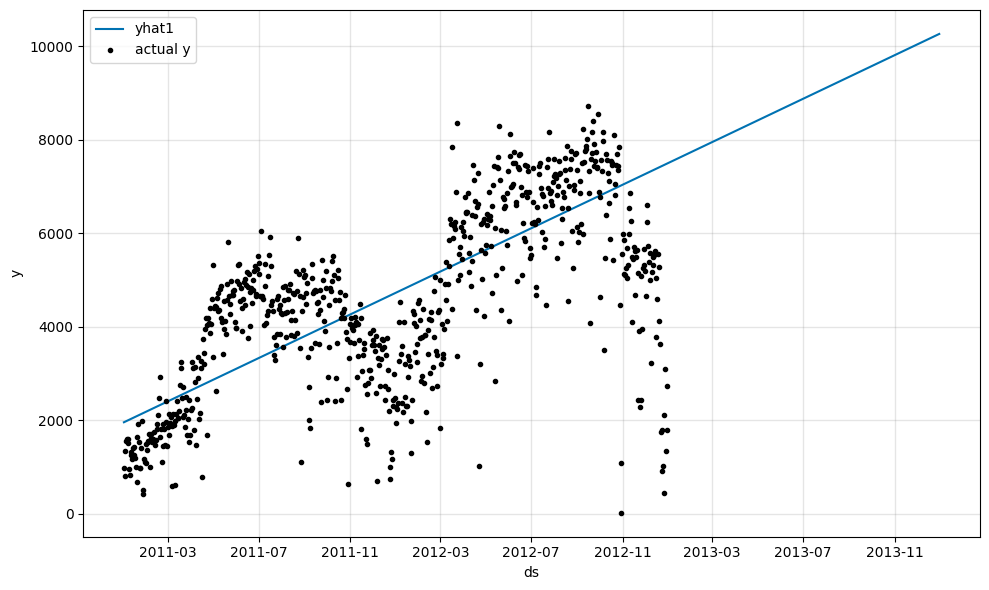

In [16]:
m = NeuralProphet(
    n_changepoints=0,
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False
)

df_future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
forecast = m.predict(df_future)
m.plot(forecast)

### Trend without changepoint + Seasonality

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

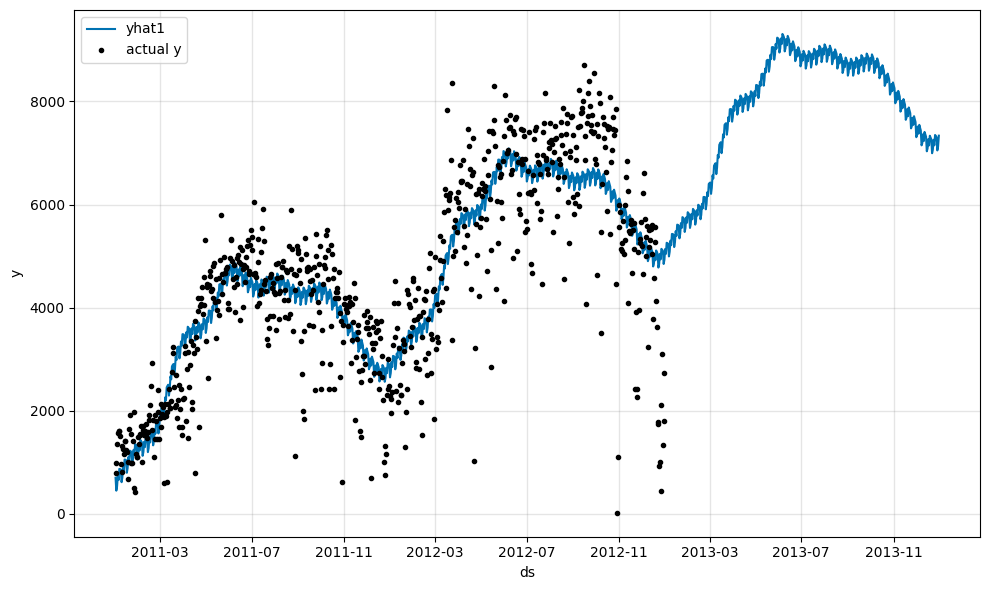

In [17]:
m = NeuralProphet(
    n_changepoints=0,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

df_future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
forecast = m.predict(df_future)
m.plot(forecast)

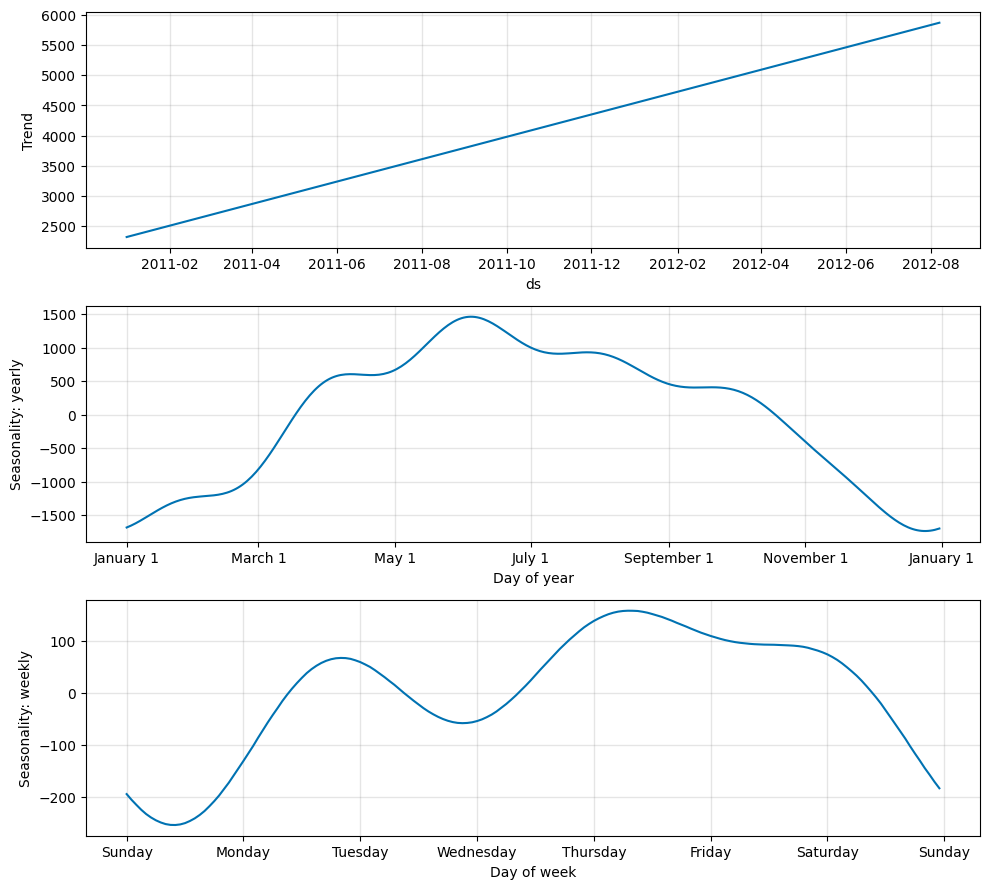

In [18]:
m.plot_parameters(components=["trend", "seasonality"])

### Trend **with** changepoint + Seasonality

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

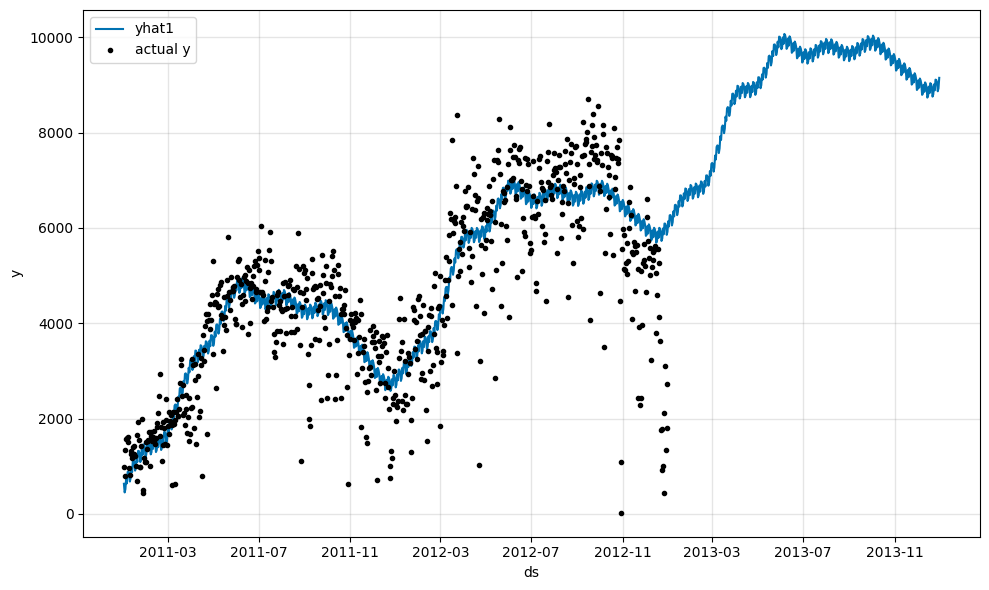

In [19]:
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

df_future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
forecast = m.predict(df_future)
m.plot(forecast)

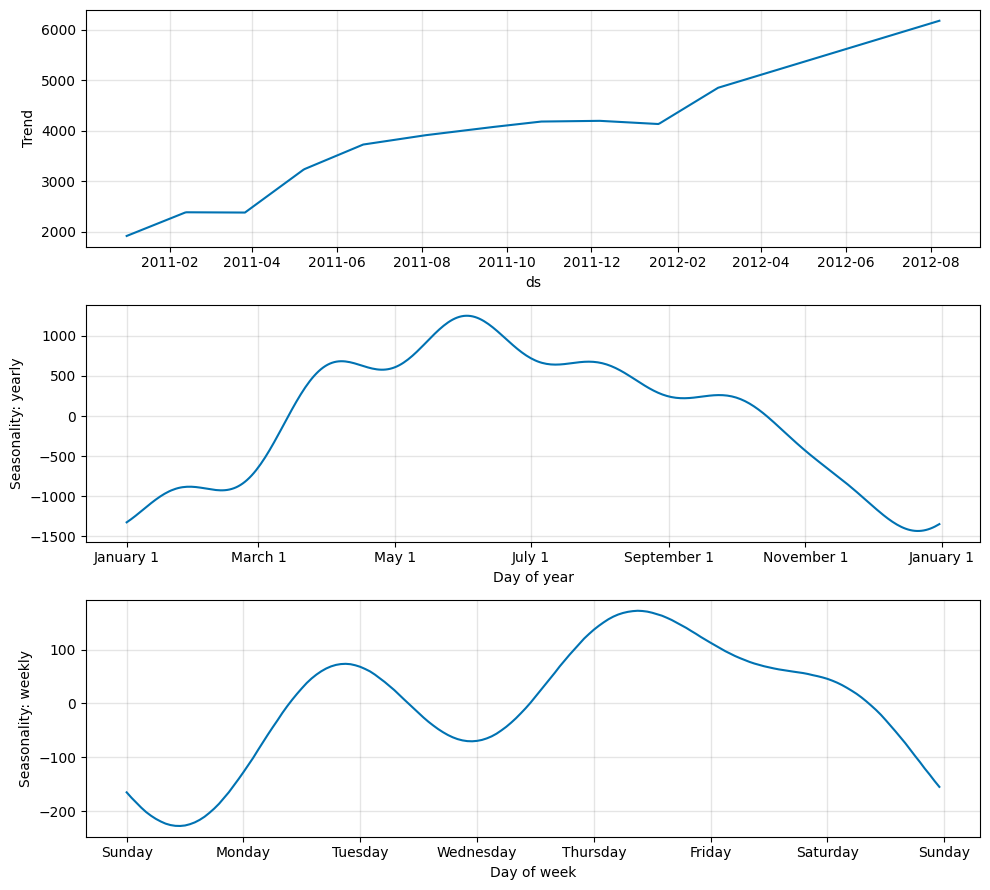

In [20]:
m.plot_parameters(components=["trend", "seasonality"])

### Trend **with** changepoint + Seasonality + Events

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

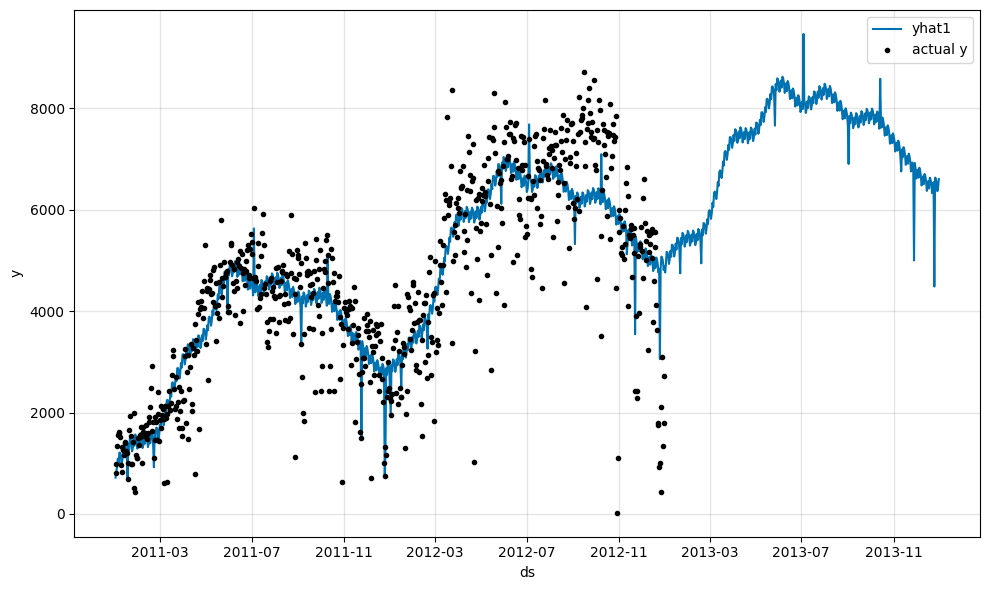

In [21]:
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

m = m.add_country_holidays("US")

df_future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
forecast = m.predict(df_future)
m.plot(forecast)

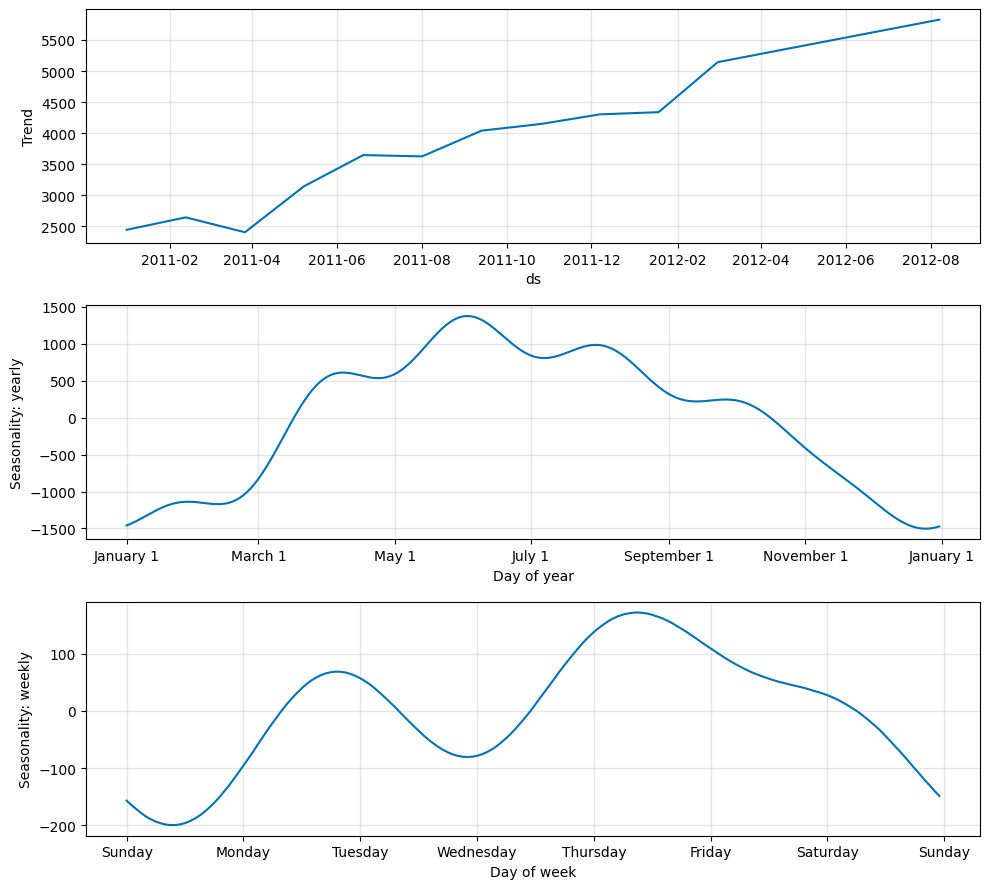

In [22]:
m.plot_parameters(components=["trend", "seasonality"])

### Trend **with** changepoint + Seasonality + Events + AR-net

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

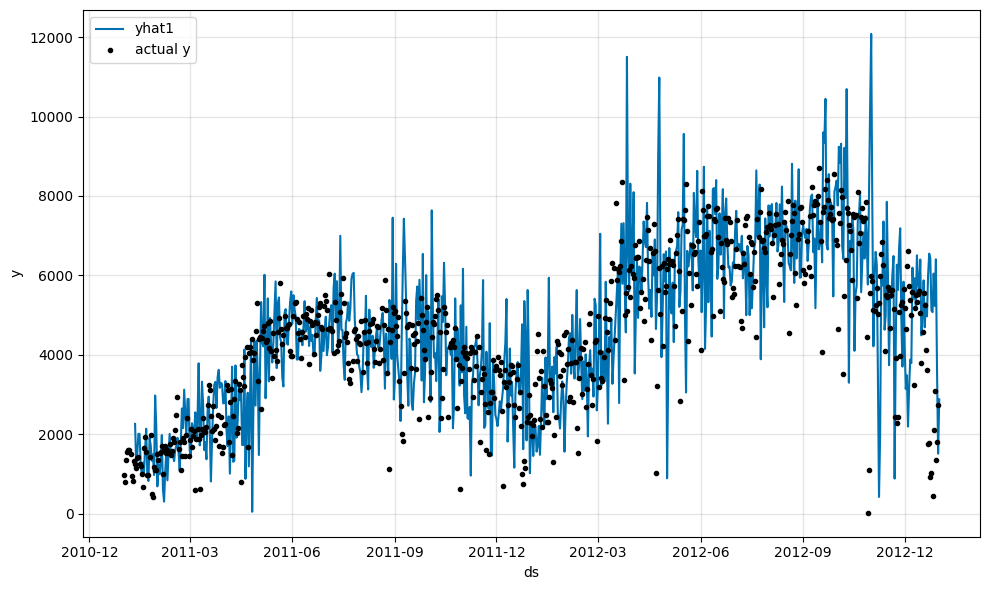

In [23]:
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags = 10
)

m = m.add_country_holidays("US")

df_future = m.make_future_dataframe(df, periods=365, n_historic_predictions=True)
m.set_plotting_backend("matplotlib")
df_train, df_test = m.split_df(df, valid_p=0.2)
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
forecast = m.predict(df_future)
m.plot(forecast)

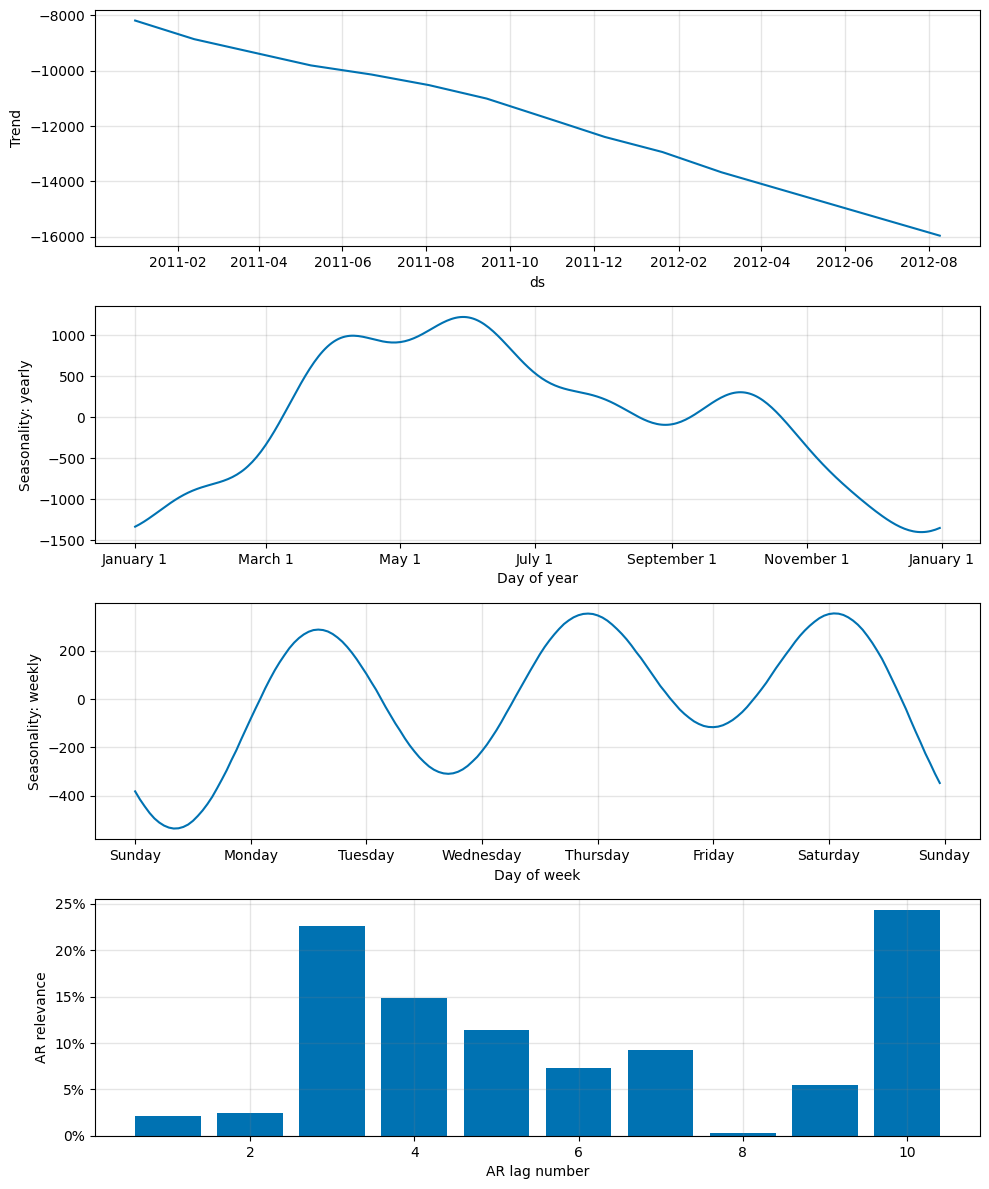

In [24]:
m.plot_parameters(components=["trend", "seasonality", "autoregression"])

### Trend **with** changepoint + Seasonality + Events + AR-net + lagged regressors + future known regressors

In [25]:
df2 = data[["ds", "cnt", "temp", "casual"]]
df2.columns = ["ds", "y", "temperature", "casual"]
df2.tail()

,ds,y,temperature,casual
726,2012-12-27,2114,0.254167,247
727,2012-12-28,3095,0.253333,644
728,2012-12-29,1341,0.253333,159
729,2012-12-30,1796,0.255833,364
730,2012-12-31,2729,0.215833,439


<Axes: >

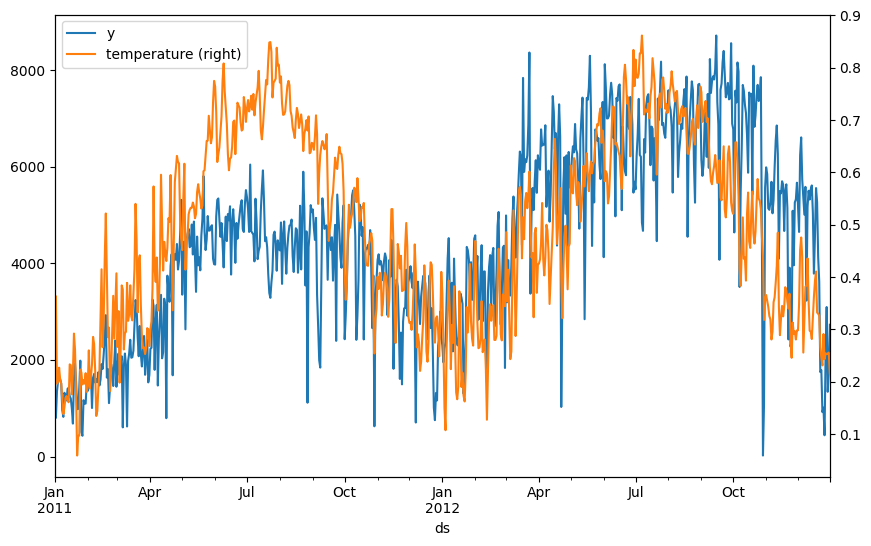

In [26]:
fig = df2.plot(x = "ds", y = "y", figsize = (10,6))
df2.plot("ds", "temperature", secondary_y=True, ax=fig)

<Axes: >

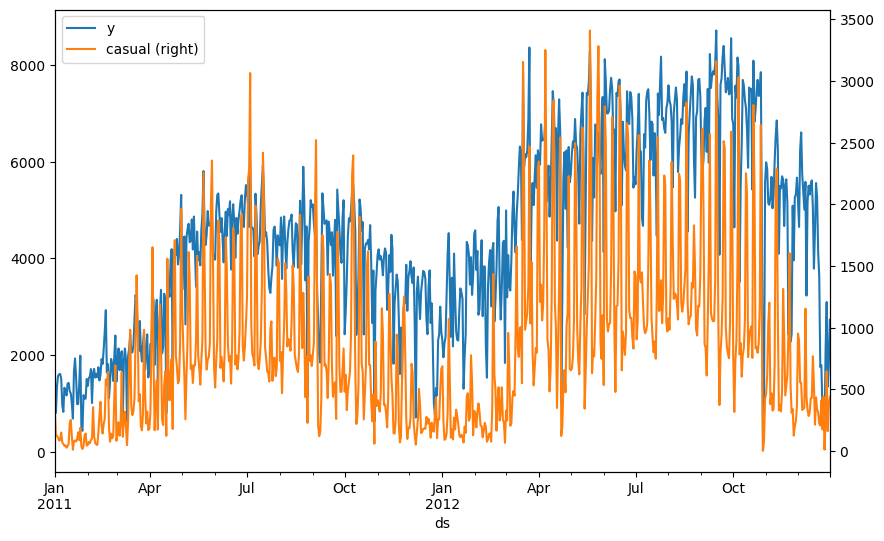

In [27]:
fig = df2.plot(x = "ds", y = "y", figsize = (10,6))
df2.plot("ds", "casual", secondary_y=True, ax=fig)

In [28]:
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags = 10,
    n_forecasts=50
)

m = m.add_country_holidays("US")
m = m.add_lagged_regressor("casual", n_lags=2)
m = m.add_future_regressor("temperature")

m.set_plotting_backend("matplotlib")
df2_train, df2_test = m.split_df(df2, valid_p=0.2)
metrics = m.fit(df2_train, validation_df=df2_test, progress="bar")
metrics.tail()

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,train_loss,reg_loss,MAE,RMSE,Loss,RegLoss
135,962.645630,1366.982666,0.059523,0.0,135,0.020514,0.0,613.155640,833.588806,0.020530,0.0
136,962.755554,1367.057251,0.059530,0.0,136,0.020513,0.0,613.380737,834.801270,0.020531,0.0
137,962.853394,1366.900391,0.059525,0.0,137,0.020511,0.0,612.220703,832.598999,0.020404,0.0
138,963.234009,1367.162476,0.059554,0.0,138,0.020509,0.0,614.427734,835.425964,0.020614,0.0
139,963.074524,1367.034668,0.059539,0.0,139,0.020507,0.0,612.719971,834.015564,0.020491,0.0


Predicting: |          | 0/? [00:00<?, ?it/s]

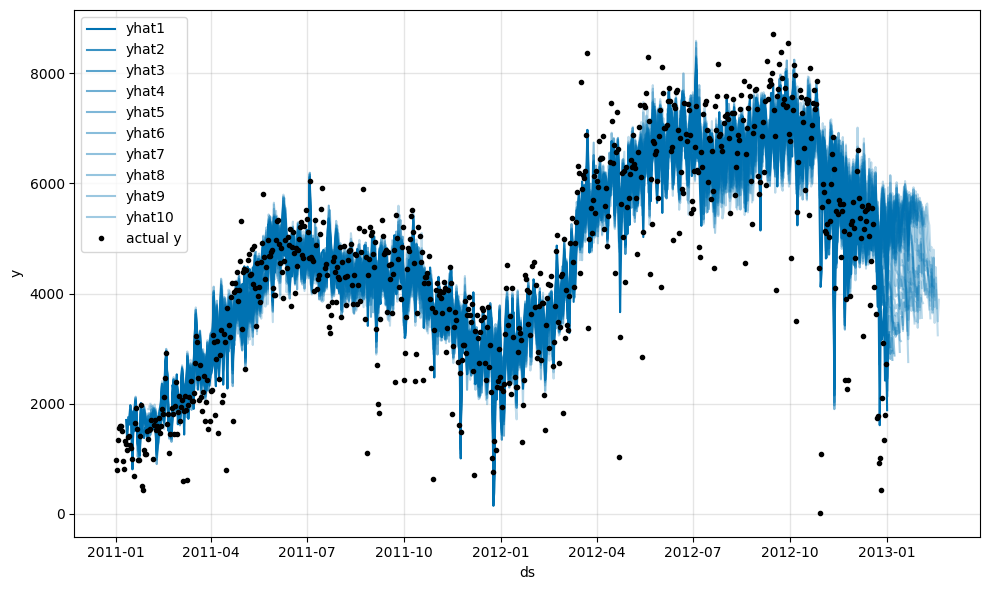

In [29]:
future_dates = pd.date_range(start=df2['ds'].max() + pd.Timedelta(days=1), periods=50, freq='D')
future_regressors = pd.DataFrame({'ds': future_dates})
future_regressors['temperature'] = df2['temperature'].iloc[-1]

future = m.make_future_dataframe(
    df=df2, 
    periods=50, 
    n_historic_predictions=True, 
    regressors_df=future_regressors
)

forecast = m.predict(future)

fig_forecast = m.plot(forecast)

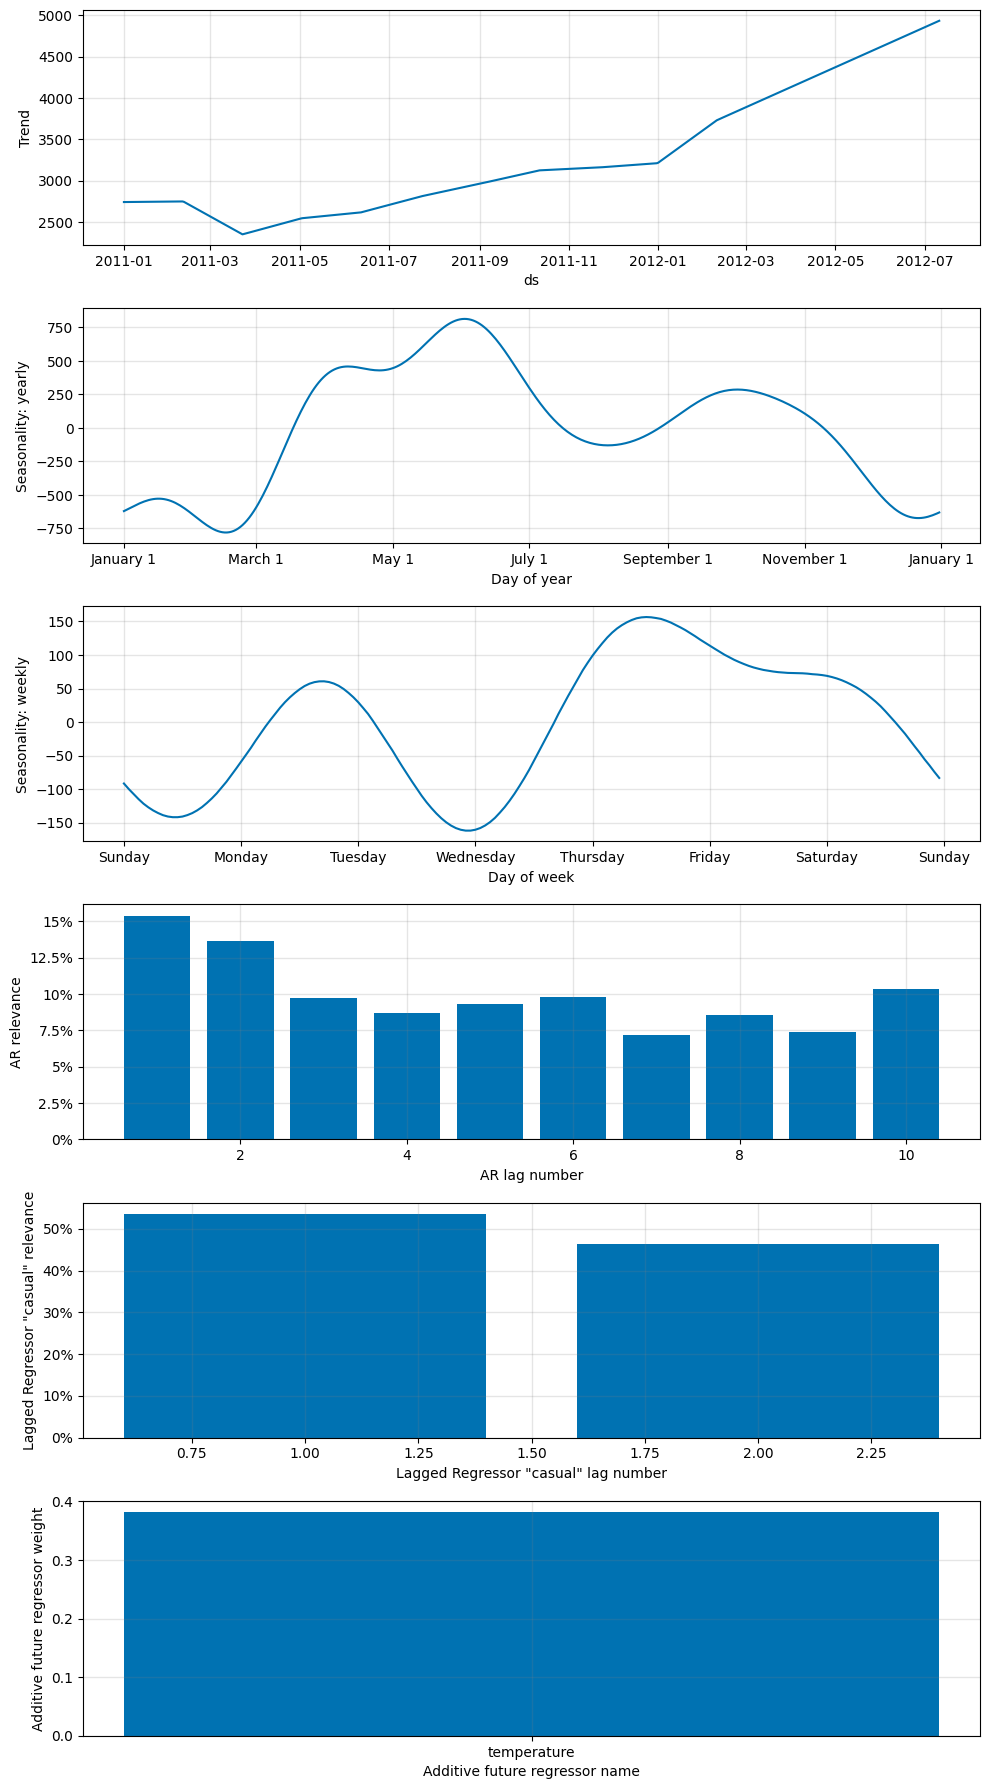

In [30]:
m.plot_parameters(components=["trend", "seasonality", "autoregression","lagged_regressors", "future_regressors"])

## Comparison with pmdarima

neuralprophet으로 추세, 계절성을 잡고 ARIMA를 통해 나머지를 적합하는 접근 방법도 가능합니다.

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Baseline NP Model Metrics:
         MAE_val     RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  \
125  1208.566650  1457.209717  0.071094          0.0    125    0.018980   
126  1207.631958  1456.014526  0.070986          0.0    126    0.018973   
127  1211.274414  1459.142456  0.071323          0.0    127    0.018978   
128  1213.953369  1461.414673  0.071573          0.0    128    0.018968   
129  1211.608765  1458.744995  0.071298          0.0    129    0.018982   

     reg_loss         MAE        RMSE      Loss  RegLoss  
125       0.0  602.659119  817.721436  0.019197      0.0  
126       0.0  606.076416  822.703064  0.019171      0.0  
127       0.0  602.263000  812.761841  0.018747      0.0  
128       0.0  595.468994  804.054626  0.018552      0.0  
129       0.0  586.667664  794.346436  0.018337      0.0  


Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/220 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

NP with AR-net Model Metrics:
        MAE_val     RMSE_val  Loss_val  RegLoss_val  epoch  train_loss  \
135  857.258362  1188.815063  0.045185          0.0    135    0.018653   
136  858.038147  1189.929932  0.045269          0.0    136    0.018646   
137  859.512939  1189.902100  0.045293          0.0    137    0.018630   
138  860.804382  1190.282227  0.045340          0.0    138    0.018626   
139  862.457092  1191.209229  0.045429          0.0    139    0.018616   

     reg_loss         MAE        RMSE      Loss  RegLoss  
135       0.0  562.739502  766.502563  0.017702      0.0  
136       0.0  593.170044  795.795898  0.018236      0.0  
137       0.0  572.626953  779.246887  0.017753      0.0  
138       0.0  567.999512  774.154663  0.017698      0.0  
139       0.0  601.150696  799.163574  0.018578      0.0  


Predicting: |          | 0/? [00:00<?, ?it/s]


Error Metrics on Test Data:
Baseline NP Forecast:
  MAE: 1211.61, RMSE: 1458.74, MAPE: 195.15%
Hybrid Forecast (NP + ARIMA):
  MAE: 1210.32, RMSE: 1458.05, MAPE: 195.13%
NP with AR-net (n_lags=10):
  MAE: 862.46, RMSE: 1191.21, MAPE: 204.41%

Comparison of Error Metrics:
  Forecasting Method          MAE         RMSE      MAPE
0        Baseline NP  1211.608625  1458.744951  1.951457
1  Hybrid (NP+ARIMA)  1210.320207  1458.052535  1.951289
2     NP with AR-net   862.457176  1191.209295  2.044103


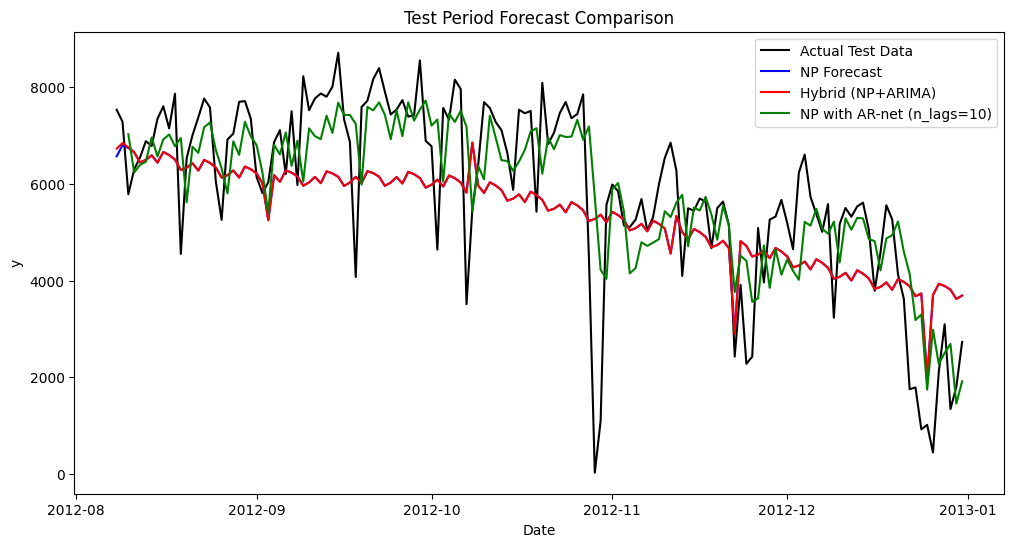

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from neuralprophet import NeuralProphet
import pmdarima as pm
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# -------------------------------
# 1. Baseline NP Forecast
# -------------------------------
# Initialize and configure the NeuralProphet model
m = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_forecasts=1
)
m = m.add_country_holidays("US")
m.set_plotting_backend("matplotlib")

# Split the data into training and test sets
df_train, df_test = m.split_df(df, valid_p=0.2)

# Fit the model on training data
metrics = m.fit(df_train, validation_df=df_test, progress="bar")
print("Baseline NP Model Metrics:")
print(metrics.tail())

# Forecast NP for the test period
df_future_test = m.make_future_dataframe(df_train, periods=len(df_test), n_historic_predictions=False)
forecast_np = m.predict(df_future_test)

# Rename the forecast column for clarity (baseline NP forecast)
df_np = forecast_np[["ds", "yhat1"]].copy()
df_np.rename(columns={"yhat1": "y_np"}, inplace=True)

# -------------------------------
# 2. Hybrid NP + ARIMA Forecast
# -------------------------------
# Compute NP predictions on the training set and calculate residuals
df_train_pred = m.predict(df_train)
residuals = df_train["y"].values - df_train_pred["yhat1"].values

# Fit an auto-ARIMA model to the residuals (non-seasonal)
model_arima = pm.auto_arima(residuals, seasonal=False)

# Forecast residuals for the test period
residuals_forecast = model_arima.predict(n_periods=len(df_test))

# Create a hybrid forecast by adding ARIMA's residual forecast to NP's forecast
df_hybrid = df_np.copy()
df_hybrid["y_arima"] = df_hybrid["y_np"] + residuals_forecast

# -------------------------------
# 3. NP with AR-net (n_lags=10)
# -------------------------------
# Initialize NP with autoregression (using 10 lagged terms)
m_ar = NeuralProphet(
    n_changepoints=10,
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    n_lags=10,
    n_forecasts=1
)
m_ar = m_ar.add_country_holidays("US")
m_ar.set_plotting_backend("matplotlib")

# Split the data and fit the model
df_train_ar, df_test_ar = m_ar.split_df(df, valid_p=0.2)
metrics_ar = m_ar.fit(df_train_ar, validation_df=df_test_ar, progress="bar")
print("NP with AR-net Model Metrics:")
print(metrics_ar.tail())

# Predict using NP with AR-net on the test set
forecast_arnet = m_ar.predict(df_test_ar)
# Ensure that the forecast dates are aligned with the test set dates
df_test_ar_sorted = df_test_ar.sort_values("ds").reset_index(drop=True)
valid_length = len(forecast_arnet)
df_arnet = pd.DataFrame({
    "ds": pd.to_datetime(df_test_ar_sorted["ds"].values[-valid_length:]),
    "y_arnet": forecast_arnet["yhat1"].values
})

# -------------------------------
# 4. Merge all forecasts with actual test values
# -------------------------------
# Prepare actual test values
df_actual = df_test[["ds", "y"]].copy()
df_actual.rename(columns={"y": "y_actual"}, inplace=True)
df_actual["ds"] = pd.to_datetime(df_actual["ds"])

# Merge forecasts from baseline NP, the hybrid NP+ARIMA, and NP with AR-net
df_merged = pd.merge(df_np, df_actual, on="ds", how="outer")
df_merged = pd.merge(df_merged, df_hybrid[["ds", "y_arima"]], on="ds", how="outer")
df_merged = pd.merge(df_merged, df_arnet, on="ds", how="outer")
df_merged.sort_values("ds", inplace=True, ignore_index=True)

# -------------------------------
# 5. Compute error metrics for each forecast
# -------------------------------
def compute_metrics(df, y_true_col, y_pred_col):
    # Compare rows where both actual and predicted values are available
    df_valid = df.dropna(subset=[y_true_col, y_pred_col])
    y_true = df_valid[y_true_col].values
    y_pred = df_valid[y_pred_col].values
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mae, rmse, mape

mae_np, rmse_np, mape_np = compute_metrics(df_merged, "y_actual", "y_np")
mae_hybrid, rmse_hybrid, mape_hybrid = compute_metrics(df_merged, "y_actual", "y_arima")
mae_arnet, rmse_arnet, mape_arnet = compute_metrics(df_merged, "y_actual", "y_arnet")

print("\nError Metrics on Test Data:")
print("Baseline NP Forecast:")
print(f"  MAE: {mae_np:.2f}, RMSE: {rmse_np:.2f}, MAPE: {mape_np:.2%}")
print("Hybrid Forecast (NP + ARIMA):")
print(f"  MAE: {mae_hybrid:.2f}, RMSE: {rmse_hybrid:.2f}, MAPE: {mape_hybrid:.2%}")
print("NP with AR-net (n_lags=10):")
print(f"  MAE: {mae_arnet:.2f}, RMSE: {rmse_arnet:.2f}, MAPE: {mape_arnet:.2%}")

metrics_df = pd.DataFrame({
    "Forecasting Method": ["Baseline NP", "Hybrid (NP+ARIMA)", "NP with AR-net"],
    "MAE": [mae_np, mae_hybrid, mae_arnet],
    "RMSE": [rmse_np, rmse_hybrid, rmse_arnet],
    "MAPE": [mape_np, mape_hybrid, mape_arnet]
})
print("\nComparison of Error Metrics:")
print(metrics_df)

# -------------------------------
# 6. Plot the Forecasts
# -------------------------------
plt.figure(figsize=(12, 6))
plt.plot(df_merged["ds"], df_merged["y_actual"], label="Actual Test Data", color="black")
plt.plot(df_merged["ds"], df_merged["y_np"], label="NP Forecast", color="blue")
plt.plot(df_merged["ds"], df_merged["y_arima"], label="Hybrid (NP+ARIMA)", color="red")
plt.plot(df_merged["ds"], df_merged["y_arnet"], label="NP with AR-net (n_lags=10)", color="green")
plt.xlabel("Date")
plt.ylabel("y")
plt.title("Test Period Forecast Comparison")
plt.legend()
plt.show()


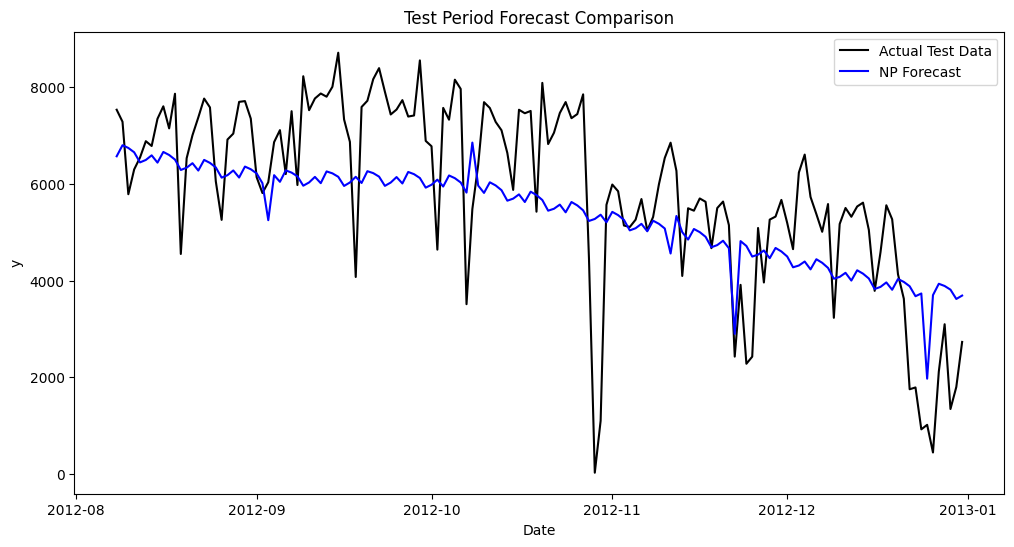

In [32]:
plt.figure(figsize=(12, 6))
plt.plot(df_merged["ds"], df_merged["y_actual"], label="Actual Test Data", color="black")
plt.plot(df_merged["ds"], df_merged["y_np"], label="NP Forecast", color="blue")
plt.xlabel("Date")
plt.ylabel("y")
plt.title("Test Period Forecast Comparison")
plt.legend()
plt.show()